# Factor Analysis using CAPM and FF factor models

In [2]:
# the main idea in factor analysis is to take a set of observed returns and decompose it into a set of explanatory returns
import pandas as pd 

In [3]:
brka_d = pd.read_csv("C:/Users/YUAN PUEN/Desktop/金融工程/JupyterLab/Data/brka_d_ret.csv", parse_dates= True, index_col=0)
brka_d.head()

,BRKA
DATE,
1990-01-02,-0.005764
1990-01-03,0.000000
1990-01-04,0.005797
1990-01-05,-0.005764
1990-01-08,0.000000


In [4]:
brka_d.tail()

,BRKA
DATE,
2018-12-24,-0.018611
2018-12-26,0.043200
2018-12-27,0.012379
2018-12-28,0.013735
2018-12-31,0.011236


In [5]:
import edhec_risk_ins as eri
%load_ext autoreload
%autoreload 2

In [7]:
brka_m = brka_d.resample('M').apply(eri.compound).to_period('M')
brka_m.head()

,BRKA
DATE,
1990-01,-0.140634
1990-02,-0.030852
1990-03,-0.069204
1990-04,-0.003717
1990-05,0.067164


In [8]:
fff = eri.get_fff_returns()
fff.head()

,Mkt-RF,SMB,HML,RF
1926-07,0.0296,-0.0230,-0.0287,0.0022
1926-08,0.0264,-0.0140,0.0419,0.0025
1926-09,0.0036,-0.0132,0.0001,0.0023
1926-10,-0.0324,0.0004,0.0051,0.0032
1926-11,0.0253,-0.0020,-0.0035,0.0031


In [18]:
import statsmodels.api as sm
from scipy import stats
import numpy as np
brka_excess = brka_m["1990":"2012-05"] - fff.loc["1990":"2012-05",["RF"]].values
mkt_excess = fff.loc["1990":"2012-05",["Mkt-RF"]]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1
lm = sm.OLS(brka_excess,exp_var).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     48.45
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           2.62e-11
Time:                        00:03:32   Log-Likelihood:                 388.47
No. Observations:                 269   AIC:                            -772.9
Df Residuals:                     267   BIC:                            -765.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.5402      0.078      6.961      0.0

In [19]:
#Interpretation: the coef of Mkt-RF is 0.54, we can say that each dollar in brka portfolio is equivalent to 46 cents in T-Bills and 54  cents in the market. It is adding alpha of 0.61% per month! although the significance is not too high

In [21]:
# Adding two more factors: HML & SMB
exp_var["Value"] = fff.loc["1990":"2012-05",["HML"]]
exp_var["Size"] = fff.loc["1990":"2012-05",["SMB"]]
exp_var.head()

,Mkt-RF,Constant,Value,Size
1990-01,-0.0785,1,0.0087,-0.0129
1990-02,0.0111,1,0.0061,0.0103
1990-03,0.0183,1,-0.0290,0.0152
1990-04,-0.0336,1,-0.0255,-0.0050
1990-05,0.0842,1,-0.0374,-0.0257


In [23]:
lm = sm.OLS(brka_excess,exp_var).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   BRKA   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.06
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           1.41e-19
Time:                        00:11:05   Log-Likelihood:                 412.09
No. Observations:                 269   AIC:                            -816.2
Df Residuals:                     265   BIC:                            -801.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.6761      0.074      9.155      0.0

### Interpretation: the result above implies that BRKA appears to be a value investor as the value coef is positive.The negative tilt on Size suggests that Hathaway tends to invest in large companies,not small companies

# Sharp style anaysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.


In [25]:
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

def style_analysis(dependent_variable, expla_variables):
    """
    Returns the optimal weights that minimizes the Tracking Error between
    a portfolio of explanatory variables and the dependent variable
    """
    n = expla_variables.shape[1] #num of columns = number of factors
    init_guess = np.repeat(1/n,n)
    bounds = ((0,1),) * n
    #construct the constraints
    weights_to_1 = {'type':'eq',
                    'fun':lambda weights: np.sum(weights)-1
    }
    solution = minimize(portfolio_tracking_error,init_guess,
                        args=(dependent_variable,expla_variables,),method='SLSQP',
                        options={'disp':False},
                        constraints=(weights_to_1),
                        bounds=bounds)
    weights = pd.Series(solution.x,index=expla_variables.columns)
    return weights

In [28]:
ind = eri.get_ins_returns()["2000":]
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531


Now construct a manager that invests 30%in Beer, 50% in Smoke and 20% in other things that have a average return of 0% and annulized vol of 15%

In [29]:
mgr_r = 0.3*ind["Beer"] + 0.5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5),size=ind.shape[0])
mgr_r.head()

2000-01   -0.045717
2000-02   -0.057912
2000-03    0.042612
2000-04    0.030109
2000-05    0.131042
Freq: M, dtype: float64

Now assume that we know nothing about the manager and his investments, all we observed was the return series. How could we tell what she was invested in?


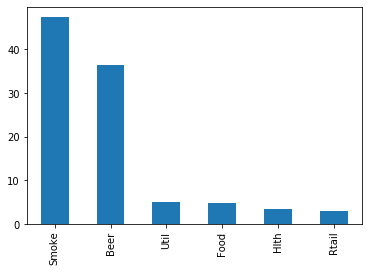

In [31]:
weights = eri.style_analysis(mgr_r,ind)*100
weights.sort_values(ascending=False).head(6).plot.bar()

In [33]:
mgr_r_2 = 0.28*ind["Food"] + 0.32*ind["Hlth"] + 0.1*ind["Beer"] + 0.1*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5),size=ind.shape[0])
mgr_r_2.head()

2000-01   -0.011765
2000-02   -0.060200
2000-03    0.030773
2000-04    0.005677
2000-05    0.079645
Freq: M, dtype: float64

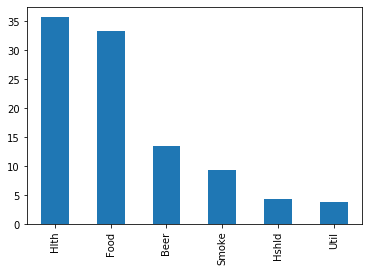

In [36]:
weights_2 = eri.style_analysis(mgr_r_2,ind)*100
weights_2.sort_values(ascending=False).head(6).plot.bar()

contrast this to the result of regression. We can see the result below using regression is much accurate.However, the negative coefficients are hard to intepret and in real-life data, those will be much larger

In [42]:
coefs = eri.regress(mgr_r,ind).params*100
print(coefs.sort_values().head())
print(coefs.sort_values().tail())

Hshld   -4.167865
Chems   -2.487617
ElcEq   -2.487456
Cnstr   -2.271333
Meals   -2.074609
dtype: float64
Steel     2.308249
Whlsl     2.481349
Rtail     6.298830
Beer     34.318045
Smoke    49.417531
dtype: float64


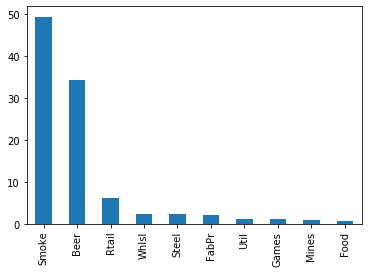

In [52]:
coefs.sort_values(ascending=False).head(10).plot.bar()

In [45]:
coefs_2 = eri.regress(mgr_r_2,ind).params*100
print(coefs_2.sort_values().head())
print(coefs_2.sort_values().tail())

FabPr   -3.479829
Rtail   -3.250219
Steel   -2.824430
Other   -2.343017
Cnstr   -1.827422
dtype: float64
Servs     3.265157
Smoke    10.933540
Beer     11.528456
Food     24.156198
Hlth     33.805995
dtype: float64


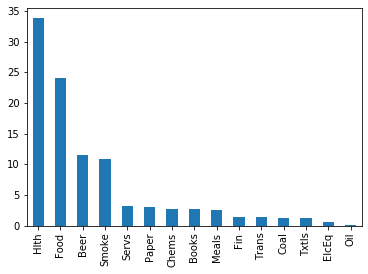

In [51]:
coefs_2.sort_values(ascending=False).head(15).plot.bar()

### Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

# Style Drift : Time varying exposures using Style analysis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

In [54]:
import edhec_risk_ins as eri 
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
ind_ew = eri.get_ins_returns(ew=True)
ind_vw = eri.get_ins_returns(ew=False)

In [61]:
ind_vw["2000":].head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2000-04,-0.0390,0.0368,0.0379,0.0220,-0.0734,0.0429,0.0430,0.0525,-0.0373,0.0648,...,-0.0790,-0.1655,-0.0630,-0.0109,0.0348,-0.0107,-0.0560,0.0382,-0.0425,0.0819
2000-05,0.1565,0.1187,0.1951,0.0119,-0.0593,0.0279,-0.0504,0.0394,-0.0010,-0.0328,...,-0.1041,-0.0892,-0.1165,-0.0137,-0.0363,0.0193,-0.0304,-0.0421,0.0506,0.0531


In [62]:
ind_ew["2000":].head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,0.0146,0.0352,0.1273,0.0556,0.0147,0.0293,-0.0050,0.2399,-0.0099,0.0153,...,0.0421,0.0457,0.1584,-0.0209,-0.0122,0.0729,-0.0487,0.0206,-0.0244,0.0627
2000-02,0.0896,-0.0162,-0.0625,0.0543,0.0541,0.0594,0.0096,0.4284,0.0175,-0.0530,...,0.2189,0.1902,0.3932,0.0210,0.0060,0.0507,0.0092,0.0185,-0.0140,0.0602
2000-03,0.0392,0.0092,-0.0301,0.0131,0.0906,0.0133,0.0704,-0.0898,0.0968,-0.0005,...,-0.0276,-0.0382,-0.0120,0.0399,0.0608,-0.0046,0.0681,0.0165,0.0184,0.0220
2000-04,-0.0385,0.0027,0.0726,-0.0869,-0.0893,-0.0429,-0.0336,-0.1372,-0.0479,-0.0011,...,-0.1752,-0.1990,-0.1616,-0.0322,-0.0239,-0.0616,-0.0718,0.0036,-0.0178,-0.0732
2000-05,0.0322,0.0233,0.1200,-0.0683,-0.0336,-0.0448,-0.0748,-0.0732,-0.0311,-0.0722,...,-0.1375,-0.1344,-0.1265,-0.0238,-0.0488,-0.0626,-0.0685,-0.0269,0.0018,-0.0620


In [63]:
sr = pd.DataFrame({"VW":eri.sharp_ratio(ind_vw["1945":],0.03,12),"EW":eri.sharp_ratio(ind_ew["1945":],0.03,12)})

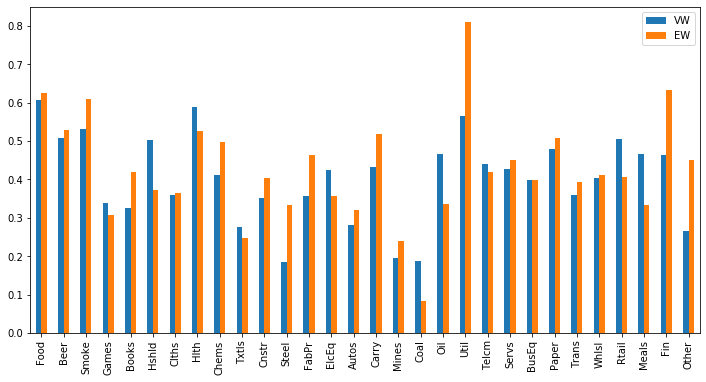

In [64]:
sr.plot.bar(figsize=(12,6))

In [67]:
(sr["EW"]>sr["VW"]).sum()/sr.shape[0]

0.6333333333333333

Text(0.5, 1.0, 'Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018')

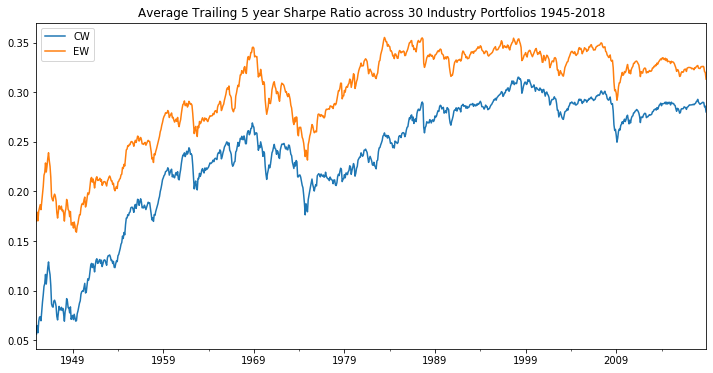

In [70]:
ax = ind_vw.rolling('1825D').apply(eri.sharp_ratio,raw=True,kwargs={"riskfree_rate":0.03,"periods_per_year":12}).mean(axis=1)["1945":].plot(figsize=(12,6),label="CW",legend=True)
ind_ew.rolling('1825D').apply(eri.sharp_ratio,raw=True,kwargs={"riskfree_rate":0.03,"periods_per_year":12}).mean(axis=1)["1945":].plot(ax=ax, label="EW", legend=True)
ax.set_title("Average Trailing 5 year Sharpe Ratio across 30 Industry Portfolios 1945-2018")

# Backtesting: EW vs VW

In [71]:
import edhec_risk_ins as eri 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
ins49_rets = eri.get_ins_returns(n_ins=49,weighting="vw")["1974":]
ins49_mcap = eri.get_ind_market_caps(n_ins=49,weights=True)["1974":]

In [75]:
ins49_rets.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.0229,0.0615,-0.0540,-0.0083,0.0301,0.0899,0.0858,-0.0101,-0.0260,0.0965,...,0.0050,0.0048,0.0552,0.0776,0.0144,0.0014,-0.0162,0.1311,0.0083,0.0102
1974-02,0.1382,0.0140,-0.0236,-0.0174,0.0185,-0.0257,-0.0032,-0.0528,-0.0342,0.0230,...,0.0156,0.0787,0.0239,0.0137,-0.0477,0.0165,-0.0219,-0.0249,0.0129,-0.0100
1974-03,-0.0157,-0.0156,-0.0406,-0.0220,-0.0600,0.0517,0.0361,0.0579,-0.0023,-0.0158,...,-0.0151,-0.0485,0.0159,-0.0452,0.0373,-0.0438,-0.0453,-0.0216,-0.0399,-0.0306
1974-04,-0.0926,-0.0265,-0.0415,-0.0366,-0.0277,-0.0749,-0.0796,-0.0646,-0.0419,-0.0477,...,-0.0269,-0.0393,-0.0194,-0.0206,-0.0296,-0.0510,-0.0919,-0.1227,-0.0684,-0.0535
1974-05,-0.0703,-0.0488,-0.0115,-0.0448,0.0559,0.0238,-0.0089,-0.0133,0.0102,-0.0691,...,-0.0130,-0.0469,-0.0390,0.0220,-0.0305,-0.1089,-0.0882,-0.1146,-0.0998,-0.0677


In [91]:
ins49_mcap.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01,0.000757,0.023874,0.014288,0.006235,0.008435,0.004557,0.002918,0.006314,0.087971,0.003453,...,0.016800,0.014330,0.005279,0.046936,0.006213,0.031837,0.020093,0.001807,0.040329,0.044887
1974-02,0.000773,0.025248,0.013489,0.006172,0.008666,0.004958,0.003160,0.006053,0.085401,0.003770,...,0.016839,0.014344,0.005555,0.050377,0.006280,0.031768,0.019675,0.002004,0.040422,0.045171
1974-03,0.000883,0.025604,0.013220,0.006077,0.008796,0.004838,0.003161,0.005738,0.082550,0.003859,...,0.017098,0.015476,0.005700,0.051104,0.006005,0.032384,0.019254,0.001954,0.040982,0.044799
1974-04,0.000891,0.025714,0.012954,0.006074,0.008467,0.005081,0.003358,0.006207,0.084434,0.003871,...,0.017267,0.015057,0.005921,0.049980,0.006376,0.031559,0.018815,0.001956,0.040202,0.044434
1974-05,0.000846,0.026251,0.013041,0.006144,0.008643,0.004822,0.003241,0.006097,0.084895,0.003852,...,0.017598,0.015178,0.006092,0.051341,0.006481,0.031371,0.017868,0.001795,0.039215,0.044104


In [92]:
ins49_mcap.loc[ins49_rets.index[0]]

Agric    0.000757
Food     0.023874
Soda     0.014288
Beer     0.006235
Smoke    0.008435
Toys     0.004557
Fun      0.002918
Books    0.006314
Hshld    0.087971
Clths    0.003453
Hlth     0.000569
MedEq    0.013567
Drugs    0.054545
Chems    0.039946
Rubbr    0.001016
Txtls    0.003284
BldMt    0.020240
Cnstr    0.003609
Steel    0.019814
FabPr    0.002715
Mach     0.028480
ElcEq    0.010062
Autos    0.036410
Aero     0.003687
Ships    0.002248
Guns     0.000653
Gold     0.002614
Mines    0.008855
Coal     0.001059
Oil      0.143377
Util     0.058969
Telcm    0.049462
PerSv    0.001208
BusSv    0.008601
Hardw    0.061485
Softw    0.000058
Chips    0.019349
LabEq    0.005966
Paper    0.010838
Boxes    0.016800
Trans    0.014330
Whlsl    0.005279
Rtail    0.046936
Meals    0.006213
Banks    0.031837
Insur    0.020093
RlEst    0.001807
Fin      0.040329
Other    0.044887
Name: 1974-01, dtype: float64

In this section we'll develop a basic infrastructure to backtest various portfolio construction techniques and compare them. Here we'll start with something quite simple and straightforward - we'll write trivially simple weight-optimizers for Equally Weighted and Cap Weighted portfolios and compare them. Obviously, there are no Covariance estimates required for either one of these weighting schemes. In following sessions we'll enhance these optimizers to use more complex weighting schemes that will rely on covariance estimates.

In [80]:
def weight_ew(r):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

def backtest_ws(r,estimation_window = 60, weighting = weight_ew):
    """
    Backtests a given weighting scheme, given some parameters:
    r: asset returns to use to build the portfolio
    estimation_window: the window to use to estimate the parameters
    weighting: the weighting scheme to use must be a function that takes "r", and a variable number  of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]]) for win in windows]
    #list -> dataframe
    weights = pd.DataFrame(weights,index=r.iloc[estimation_window-1:].index,columns=r.columns)
    returns = (weights*r).sum(axis="columns",min_count=1) #min_count is to genereate NAs if all inputs are NAs
    return returns

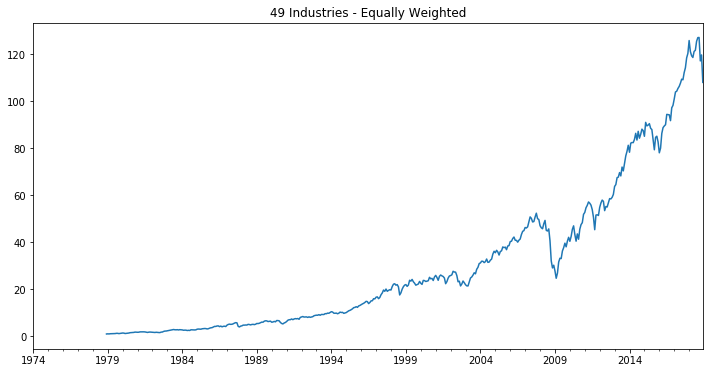

In [81]:
ewr = backtest_ws(ins49_rets, weighting=weight_ew)
ewi = (1+ewr).cumprod()
ewi.plot(figsize=(12,6), title="49 Industries - Equally Weighted");

Now, let's add capweighting. We'll need to compute capweights, which we've already been provided through the marketcap file. We can refactor the code we've developed in the past to add a convenience function to our toolkit. Note the use of `**kwargs` to be able to take a variable number of keyword arguments to the function so that we can call any weighting function and let that weighting function take care of whatever arguments it needs. We'll have to refactor `weight_ew` with this new signature, but thats the only change (for now) for `weight_ew`.

In [82]:
def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    return cap_weights.loc[r.index[0]]

def backtest_ws(r, estimation_window=60, weighting=weight_ew, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert list of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

In [85]:
ewr = backtest_ws(ins49_rets)
cwr = backtest_ws(ins49_rets,weighting=weight_cw,cap_weights = ins49_mcap)
btr = pd.DataFrame({"EW":ewr,"CW":cwr})

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.102331,-0.528292
CW,0.120165,0.147544,-0.717960,5.562648,0.065636,0.093769,0.093769,-0.515999


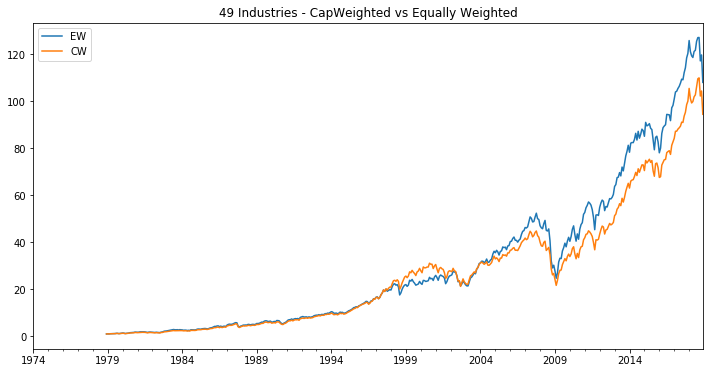

In [90]:
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industries - CapWeighted vs Equally Weighted")
eri.Summary_Stats(btr.dropna())

Equal weighted portfolio sometimes is not realistic cuz it means that you will have to hold a huge position in tiny companies. So if they have small market cap, you simply cannot hold as much of that company as you can of IBM or Apple..large companies. Think about trading cose as well!

### Improve EW with capweight tethering

Often in practice, we'll want to implement some sort of a modification of a pure strategy. For instance, although Equal Weight portfolios are popular, they'll be constrained in some way - for instance to match the sector weights of the cap-weighted benchmark or to make sure that microcap stocks are not overweighted. The motivation for doing so could be to make a portfolio more tradeable (e.g. some microcaps may not have the liquidity) or to improve the tracking error to the Cap-Weighted index.

As an illustration of how that can be achieved, we enhance our simple `weight_ew` allocator to (i) ** drop microcap stocks beyond a particular threshold **, and (ii) ** impose a constraint that ensures that the maximum weight assigned to any stock is no more than some multiple of the weight it would be in a cap-weighted portfolio **.

In [94]:
def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted 
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult) #make sure that ew <= mutiples * cap weights
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[0]]
    return w/w.sum()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawdown
EW,0.123921,0.160660,-0.759092,6.659028,0.071404,0.102331,0.102331,-0.528292
EW-Tethered,0.125572,0.156923,-0.752967,6.187433,0.069778,0.099191,0.099191,-0.530654
CW,0.120165,0.147544,-0.717960,5.562648,0.065636,0.093769,0.093769,-0.515999


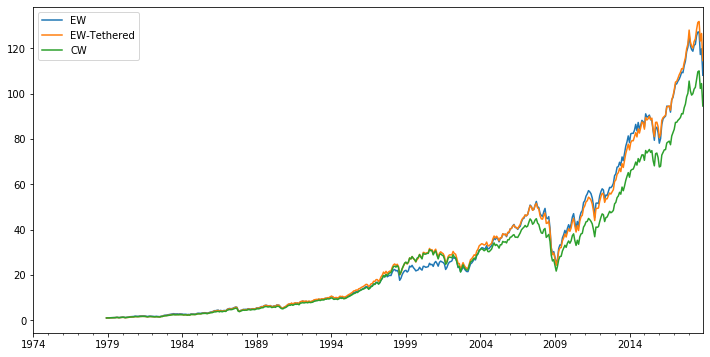

In [97]:
ewr = backtest_ws(ins49_rets)
ewr_thether = backtest_ws(ins49_rets,weighting=weight_ew,cap_weights=ins49_mcap,max_cw_mult = 5, microcap_threshold=0.005)
cwr = backtest_ws(ins49_rets,weighting=weight_cw,cap_weights=ins49_mcap)
btr_new = pd.DataFrame({"EW": ewr, "EW-Tethered": ewr_thether, "CW": cwr})
(1+btr_new).cumprod().plot(figsize=(12,6))
eri.Summary_Stats(btr_new.dropna())

## A Final Note ...

One of the motivations of adding the tethering constraint is to improve tracking error to the cap-weighted portfolio. Let's see if we did manage to achieve that:

In [100]:
eri.tracking_error(ewr, cwr),eri.tracking_error(ewr_thether, cwr)

(0.23402341787849118, 0.15661830578201005)